In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [3]:
ls

analisis_data1.ipynb                 PERCOBAAN_2_2020-08-25-13-51-35.bag
analisis_data3.ipynb                 PERCOBAAN_3_2020-08-25-13-57-17.bag
PERCOBAAN_1_2020-08-25-13-35-44.bag  README.txt


In [4]:
bag = rosbag.Bag('PERCOBAAN_3_2020-08-25-13-57-17.bag')
print(bag)

path:        PERCOBAAN_3_2020-08-25-13-57-17.bag
version:     2.0
duration:    59.2s
start:       Aug 25 2020 13:57:17.45 (1598338637.45)
end:         Aug 25 2020 13:58:16.61 (1598338696.61)
size:        6.5 MB
messages:    20396
compression: none [9/9 chunks]
types:       diagnostic_msgs/DiagnosticArray       [60810da900de1dd6ddd437c3503511da]
             dynamic_reconfigure/Config            [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription [757ce9d44ba8ddd801bb30bc456f946f]
             geometry_msgs/Twist                   [9f195f881246fdfa2798d1d3eebca84a]
             geometry_msgs/TwistStamped            [98d34b0043a2093cf9d9345ab6eef12e]
             nav_msgs/Odometry                     [cd5e73d190d741a2f92e81eda573aca7]
             pkg_ta/Control                        [f3ff5e621674977340f826fa8303fddf]
             pkg_ta/LogArduino                     [794f6f831f1064c1b29b65087ebb232f]
             rosgraph_msgs/Log                     

In [5]:
cs_t = []
cs_action_throttle = []
cs_action_steer = []
cs_error_lateral = []
cs_error_yaw = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_curvature = []
cs_wp_idx = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
    cs_action_steer.append(msg.action_steer)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_curvature.append(msg.ref_curvature)
    cs_wp_idx.append(msg.wp_idx)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_steer = np.array(cs_action_steer)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_curvature = np.array(cs_ref_curvature)
cs_wp_idx = np.array(cs_wp_idx)

In [6]:
a_t = []
a_steering_setpoint = []
a_steering_angle = []
a_throttle_voltage = []
for topic, msg, _ in bag.read_messages(topics=['/logging_arduino']):
    a_t.append(msg.header.stamp.to_sec())
    a_steering_setpoint.append(msg.steering_setpoint )
    a_steering_angle.append(msg.steering_angle)
    a_throttle_voltage.append(msg.throttle_voltage)
a_t = np.array(a_t)
a_steering_setpoint = np.array(a_steering_setpoint)
a_steering_angle = np.array(a_steering_angle)
a_throttle_voltage = np.array(a_throttle_voltage)

# PLOT HASIL

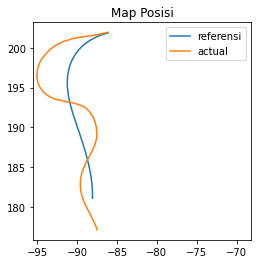

In [7]:
plt.plot(cs_ref_x, cs_ref_y, label='referensi')
plt.plot(cs_actual_x, cs_actual_y, label='actual')
plt.legend()
plt.axis('square')
plt.title('Map Posisi')
plt.show()

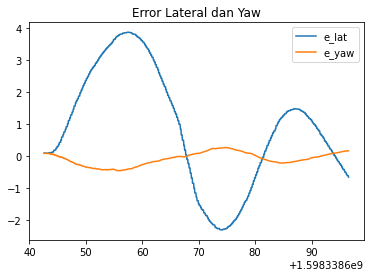

In [8]:
plt.plot(cs_t, cs_error_lateral, label='e_lat')
plt.plot(cs_t, cs_error_yaw, label='e_yaw')
plt.legend()
plt.title('Error Lateral dan Yaw')
plt.show()

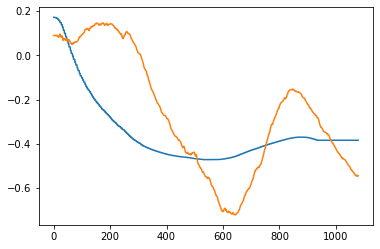

In [9]:
plt.plot(cs_ref_yaw)
plt.plot(cs_actual_yaw)

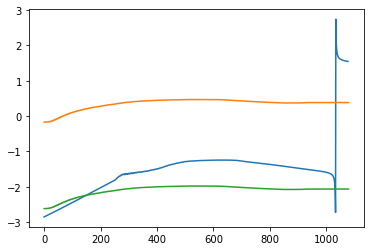

In [10]:
# Ngecek apakah sesuai atau tidak
# Ternyata yaw nya emang ada bias, kayaknya kita harus cek si yaw nya dulu Pras
# Saat balik arah, apakah dia balik 180 derajatttt ?

rdx = cs_ref_x[2:]-cs_ref_x[:-2]
rdy = cs_ref_y[2:]-cs_ref_y[:-2]
rdx = savgol_filter(rdx, 501, 3)
rdy = savgol_filter(rdy, 501, 3)
ref_yaw = np.arctan2(rdy, rdx)

plt.plot(ref_yaw)
plt.plot(-cs_ref_yaw)
plt.plot(-cs_ref_yaw+ref_yaw[150]-(-cs_ref_yaw[150]))

# Sinyal Aktuator

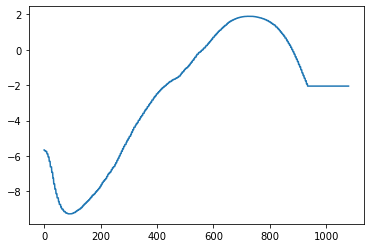

In [11]:
# Lho kenapa negatif (CW) ? Bukannya harusnya + (CCW)
plt.plot(np.arcsin(2.*cs_ref_curvature)*180/np.pi)

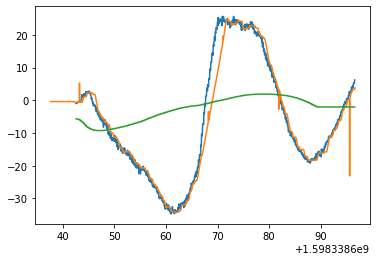

In [12]:
# Ga ketinggalan-ketinggalan banget Pras
plt.plot(cs_t, cs_action_steer)
plt.plot(a_t, a_steering_angle)
plt.plot(cs_t, np.arcsin(2.*cs_ref_curvature)*180/np.pi)

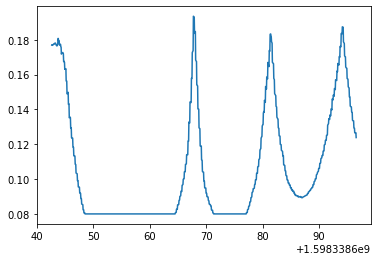

In [13]:
plt.plot(cs_t, cs_action_throttle)

In [14]:
f_t = []
f_v = []
for topic, msg, _ in bag.read_messages(topics=['/odometry/filtered_map']):
    f_t.append(msg.header.stamp.to_sec())
    v = msg.twist.twist.linear
    f_v.append(np.sqrt(v.x**2 + v.y**2))
f_t = np.array(f_t)
f_v = np.array(f_v)

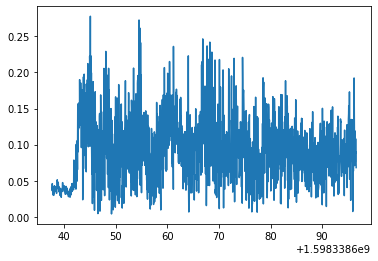

In [15]:
# SPEED
plt.plot(f_t, f_v)

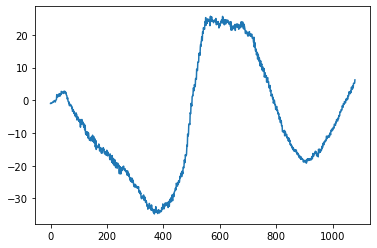

In [16]:
plt.plot(cs_action_steer)

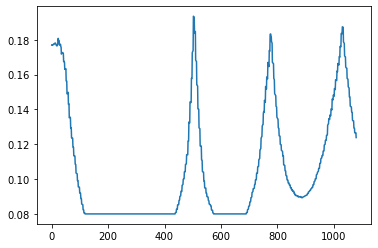

In [17]:
plt.plot(cs_action_throttle)

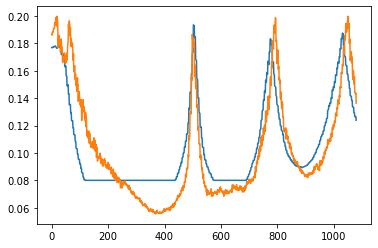

In [18]:
plt.plot(cs_action_throttle)
plt.plot(0.2/(1 + 0.075*np.abs(cs_action_steer)))